# Import necessesary packages and libraries

In [1]:
import numpy as np
import pandas as pd
import PIL as pil
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from os.path import isfile, join
import tempfile
import pickle
%matplotlib inline

# EDA

### Extract filenames for all images

In [2]:
tumor_filebase_str = 'Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/'
tumor_files = [f for f in listdir(tumor_filebase_str) if isfile(join(tumor_filebase_str, f))]

healthy_filebase_str = 'Brain Tumor Data Set/Brain Tumor Data Set/Healthy/'
healthy_files = [f for f in listdir(healthy_filebase_str) if isfile(join(healthy_filebase_str, f))]

### Total # of Images

In [3]:
len(tumor_files) + len(healthy_files)

4600

### Extract picture dimensions

In [4]:
#get consolidated list that includes filepaths for all cancerous/healthy images
all_pic_files = [tumor_filebase_str + x for x in tumor_files.copy()] + [healthy_filebase_str + x for x in healthy_files.copy()]
#object to store picture dimensions
pic_dims = []
for filename in all_pic_files: #loop through all pictures and store picture dimensions
    img_size = pil.Image.open(filename).convert('L').size
    pic_dims.append(img_size)
    
pic_dims = pd.DataFrame(pic_dims,columns=['Grayscale Row Dimensions','Grayscale Column Dimensions'])

### Analysis of Picture Dimensions

In [5]:
pic_dims.head()

,Grayscale Row Dimensions,Grayscale Column Dimensions
0,512,512
1,240,300
2,256,256
3,512,512
4,256,256


#### Average Row and Column Dimensions

In [6]:
print('Average Row Dimensions: ' + str(round(pic_dims['Grayscale Row Dimensions'].mean(),2)))
print('Average Column Dimensions: ' + str(round(pic_dims['Grayscale Column Dimensions'].mean(),2)))

Average Row Dimensions: 359.49
Average Column Dimensions: 378.67


#### Average Pixels (Feature Dimensions) Per Image

In [7]:
round(pic_dims.apply(lambda x:x['Grayscale Row Dimensions']*x['Grayscale Column Dimensions'],axis=1).mean(),2)

165192.37

#### Proportion Breakdown of Unique Picture Dimension Sizes

In [8]:
dim_breakdown = pic_dims.apply(lambda x:str(x['Grayscale Row Dimensions']) + ', ' + 
               str(x['Grayscale Column Dimensions']),axis=1).value_counts()/len(pic_dims)
dim_breakdown

512, 512    0.192391
225, 225    0.079565
630, 630    0.031087
256, 256    0.022826
236, 236    0.019348
              ...   
207, 207    0.000217
236, 221    0.000217
236, 203    0.000217
244, 274    0.000217
219, 234    0.000217
Length: 459, dtype: float64

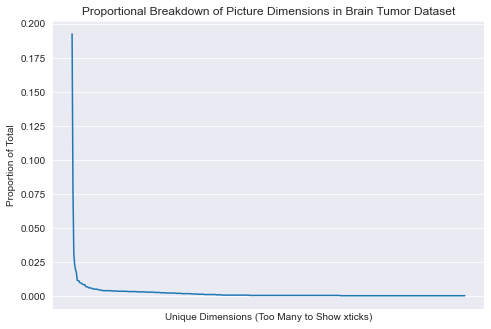

In [9]:
sns.set_style('darkgrid')
fig = plt.figure()
axes = fig.add_axes([0,0,1,1])
axes.plot(dim_breakdown)
axes.set_xlabel('Unique Dimensions (Too Many to Show xticks)')
axes.get_xaxis().set_ticks([])
axes.set_ylabel('Proportion of Total')
axes.set_title('Proportional Breakdown of Picture Dimensions in Brain Tumor Dataset')
plt.show()

#### Proportion of Square Images

In [10]:
(pic_dims['Grayscale Row Dimensions'] == pic_dims['Grayscale Column Dimensions']).sum()/len(pic_dims)

0.37521739130434784

#### Proportion of Square/Near-Square Images defined by column dimensions within 20% of row dimensions

In [11]:
((pic_dims['Grayscale Column Dimensions'] <= (1.2*pic_dims['Grayscale Row Dimensions'])) & (pic_dims['Grayscale Column Dimensions'] >= (0.8*pic_dims['Grayscale Row Dimensions']))).sum()/len(pic_dims)

0.7584782608695653

# IMAGE DIMENSION STANDARDIZATION PIPELINE

### Function to Standardize Singular Image

In [12]:
def standardize_image_dimensions(filename,newdim=(360,360),show_difference=True):
    '''
    Ingest image and output a greyscale version of the image that is a modified size while preserving aspect ratios
    '''
    img = pil.Image.open(filename).convert('L') #open image as a grayscale
    img_size = img.size #capture image dimensions
    img_size = (img_size[1],img_size[0]) #store in height by width rather than width by height aka rowsize x colsize
    
    if show_difference == True: #show before standardization
        display(img)
    
    if img_size[0] == img_size[1]: #if image is already square, we can resize while preserving aspect ratios of original image
        img_array = np.array(img) #convert image to array
        
        if show_difference == True:
            plt.imshow(img_array,cmap='gray')
    else:
        gap = abs(img_size[0] - img_size[1]) #calculate difference between dimensions to ID space we need to fill on shorter dimensions
        gapfill_1 = int(gap/2) #space we will fill on one side of shorter dimension
        gapfill_2 = gap-gapfill_1 #space we will fill on other side
        img_array = np.asarray(img) #convert image to array
        
        if img_size[0] < img_size[1]: #If rows are less than columns, fill rowspace with empty ink signal symmetrically s.t. the image is square
            img_array = np.vstack((np.zeros((gapfill_1,img_size[1])),img_array)) #fill top
            img_array = np.vstack((img_array,np.zeros((gapfill_2,img_size[1])))) #fill bottom
        else: #if columns are less than rows, fill column space with empty ink signal symmetrically s.t. the image is square
            img_array = np.hstack((np.zeros((img_size[0],gapfill_1)),img_array)) #fill left
            img_array = np.hstack((img_array,np.zeros((img_size[0],gapfill_2)))) #fill right
        
    #resize new image according to user defined size
    temp = tempfile.TemporaryFile() #create temporary file
    plt.imsave(temp,img_array,cmap='gray') #save array representation of image as image
    new_image = pil.Image.open(temp).convert('L') #open image
    new_image = new_image.resize(newdim) #resize image
    
    if show_difference == True: #show after standardization
        display(new_image)
    
    #return standardized image and vectorized version of standardized image
    return new_image,np.array(new_image)

### Example of Function in Action -- Image Before and After Standardization

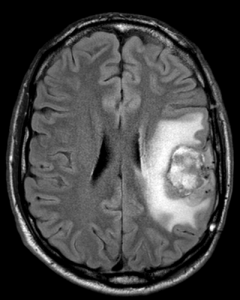

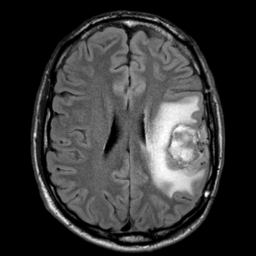

In [13]:
a,b = standardize_image_dimensions(all_pic_files[1],newdim=(256,256))

### Function to Standardize Dataset

In [14]:
def standardize_image_dataset(filename_list,newdim=(360,360)):
    labeled_dataframe = pd.DataFrame(np.zeros((len(filename_list),newdim[0]*newdim[1] + 1))) #create dataframe to that stores
    #vectorized versions of images -- initial labeled dataset
    #Create column names
    colNames = ['pixel' + str(x) for x in range(1,newdim[0]*newdim[1] + 1)]
    colNames.append('label')
    labeled_dataframe.columns = colNames
    
    #counters for saving each image as a unique filename in the proper location
    healthy_counter = 0
    cancerous_counter = 0
    
    for num in range(len(filename_list)):
        filename = filename_list[num] #get filename
        img,img_asarray = standardize_image_dimensions(filename,newdim,False) #get standardized/vectorized version of image
        if '/Cancer' in filename: #if cancer is in filename, save in proper folder and add to labeled data with label = 1
            cancerous_counter = cancerous_counter + 1
            img.save('Amit/Standardized Images/Cancerous/Cancer' + str(cancerous_counter) + '.jpg') #Save in cancer folder
            #Store vectorized version of image as 1 dimensional array
            new_data = list(img_asarray.flatten())
            new_data.append(1)
            labeled_dataframe.iloc[num] = new_data
        else:#if cancer is in filename, save in proper folder and add to labeled data with label = 1
            healthy_counter = healthy_counter + 1
            img.save('Amit/Standardized Images/Healthy/Healthy' + str(healthy_counter) + '.jpg') #Save in cancer folder
            #Store vectorized version of image as 1 dimensional array
            new_data = list(img_asarray.flatten())
            new_data.append(0)
            labeled_dataframe.iloc[num] = new_data
    
    #save labeled data as a dataframe using to_pickle (read_pickle to read dataframe in for further analysis and model development)
    labeled_dataframe = labeled_dataframe.astype('uint8')
    labeled_dataframe.to_pickle('Amit/Labeled Data/labeled_data.pkl')

In [15]:
standardize_image_dataset(all_pic_files,newdim=(256,256))